# Przykład wykonania analizy za pomocą bibliteki revoscalepy w wewnętrznym kontekście serwera SQL 

https://docs.microsoft.com/pl-pl/r-server/python-reference/revoscalepy/rxinsqlserver

### Informacje o środowisku wykonawczym

In [1]:
import sys
import revoscalepy


Express Edition will continue to be enforced.


In [2]:
print('Wersja modułu revoscalepy: ', revoscalepy.__version__)
print('Ścieżka do biblioteki revoscalepy: ', revoscalepy.__path__)
print('Wersja języka Python: ', sys.version)
print('Ścieżka do interpretera: ', sys.executable)

Wersja modułu revoscalepy:  9.2.0
Ścieżka do biblioteki revoscalepy:  ['D:\\Microsoft SQL Server\\MSSQL14.MSSQLSERVER\\PYTHON_SERVICES\\lib\\site-packages\\revoscalepy']
Wersja języka Python:  3.5.2 |Continuum Analytics, Inc.| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]
Ścieżka do interpretera:  D:\Microsoft SQL Server\MSSQL14.MSSQLSERVER\PYTHON_SERVICES\python.exe


In [3]:
del revoscalepy #małe czyszczenie

---

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

### Utworzenie kontekstu obliczeniowego wewnątrz serwera MS SQL 2017
- RxInSqlServer - klasa tworząca kontekst obliczeniowy na serwerze SQL
- RxSqlServerData - klasa realizująca dostęp do zestawu danych określonych przez zapytanie i umiejscowionych na serwerze SQL

In [5]:
from revoscalepy import RxSqlServerData, RxInSqlServer, rx_lin_mod

In [6]:
connection_string="Driver=SQL Server;Server=.;Database=RevoTestDB;Trusted_Connection=True"

In [7]:
cc = RxInSqlServer(
    connection_string = connection_string,
    num_tasks = 1,
    auto_cleanup = False,
    console_output = True,
    execution_timeout_seconds = 0,
    wait = True
    )

In [8]:
type(cc)

revoscalepy.computecontext.RxInSqlServer.RxInSqlServer

In [9]:
query="select top 600000 [ArrDelay],[CRSDepTime],[DayOfWeek] FROM airlinedemosmall"

In [10]:
data_source = RxSqlServerData(
    sql_query = "select top 600000 * from airlinedemosmall",
    connection_string = connection_string,
    column_info = {
        "ArrDelay" : { "type" : "integer" },
        "DayOfWeek" : {
            "type" : "factor",
            "levels" : [ "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday" ]
        }
    })

In [11]:
type(data_source)

revoscalepy.datasource.RxSqlData.RxSqlServerData

In [12]:
data_source.head(num_rows = 6, report_progress = 3)

ReadNum=1, StartRowNum=1, CurrentNumRows=6, TotalRowsProcessed=6, ReadTime=0.009, ProcessDataTime = 0.001, LoopTime = 0.01 

Overall compute summaries time: 0.010 secs.
Total loop time: 0.01
Total read time for 1 reads: 0.009
Total process data time: Less than .001 seconds
Average read time per read: 0.009
Average process data time per read: Less than .001 seconds
Number of threads used: 2


,ArrDelay,CRSDepTime,DayOfWeek
0,6,9.666666,Monday
1,-8,19.916666,Monday
2,-2,13.750000,Monday
3,1,11.750000,Monday
4,-2,6.416667,Monday
5,-14,13.833333,Monday


### Pobranie podstawowych informacji o obiekcie *revoscalepy data source*

In [13]:
from revoscalepy import rx_get_info, rx_get_var_info, rx_get_var_names, rx_summary

In [14]:
info = rx_get_info(data_source)
print(info)

Connection string:Driver=SQL Server;Server=.;Database=RevoTestDB;Trusted_Connection=True
Data Source:SqlServer



In [15]:
var_info = rx_get_var_info(data_source)
print(var_info)

Var 1: ArrDelay, Type: integer, Storage: int32, Low/High: (-86.0000, 1490.0000)
Var 2: CRSDepTime, Type: numeric, Storage: float64, Low/High: (0.0167, 23.9833)
Var 3: DayOfWeek
	7 factor levels: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']



In [16]:
name_info = rx_get_var_names(data_source)
print(name_info)


ArrDelay CRSDepTime DayOfWeek


In [17]:
info = rx_get_info(data_source, get_var_info=True)
print(info)

Connection string:Driver=SQL Server;Server=.;Database=RevoTestDB;Trusted_Connection=True
Data Source:SqlServer
Number of variables:3.0
Variable information: 
Var 1: ArrDelay, Type: integer, Storage: int32
Var 2: CRSDepTime, Type: numeric, Storage: float64
Var 3: DayOfWeek
	7 factor levels: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']



In [18]:
summary = rx_summary("ArrDelay+DayOfWeek", data_source)
print(summary)

Rows Read: 600000, Total Rows Processed: 600000, Total Chunk Time: 1.252 seconds 
Computation time: 1.313 seconds.
Call:
rx_summary(formula = 'ArrDelay+DayOfWeek', data = <revoscalepy.datasource.RxSqlData.RxSqlServerData object at
    0x000001E29C3C0C88>, by_group_out_file = None, summary_stats = ['Mean', 'StdDev', 'Min', 'Max', 'ValidObs',
    'MissingObs'], by_term = True, pweights = None, fweights = None, row_selection = None, transforms = None,
    transform_objects = None, transform_function = None, transform_variables = None, transform_packages = None,
    transform_environment = None, overwrite = False, use_sparse_cube = False, remove_zero_counts = False,
    blocks_per_read = 1, rows_per_block = 100000, report_progress = None, verbose = 0, compute_context =
    <revoscalepy.computecontext.RxLocalSeq.RxLocalSeq object at 0x000001E29A52E908>)

Summary Statistics Results for: ArrDelay+DayOfWeek

Number of valid observations: 600000.0

       Name       Mean     StdDev   Min     Ma

### Dane z obiektu *data_source* można zaimportować do obiektu *DataFrame* z biblioteki *Pandas* 

In [19]:
from revoscalepy import rx_import

In [20]:
df = pd.DataFrame(rx_import(input_data = data_source))

Rows Read: 600000, Total Rows Processed: 600000, Total Chunk Time: 1.343 seconds 


DayOfWeek
Monday       [[Axes(0.125,0.125;0.775x0.755)]]
Tuesday      [[Axes(0.125,0.125;0.775x0.755)]]
Wednesday    [[Axes(0.125,0.125;0.775x0.755)]]
Thursday     [[Axes(0.125,0.125;0.775x0.755)]]
Friday       [[Axes(0.125,0.125;0.775x0.755)]]
Saturday     [[Axes(0.125,0.125;0.775x0.755)]]
Sunday       [[Axes(0.125,0.125;0.775x0.755)]]
dtype: object

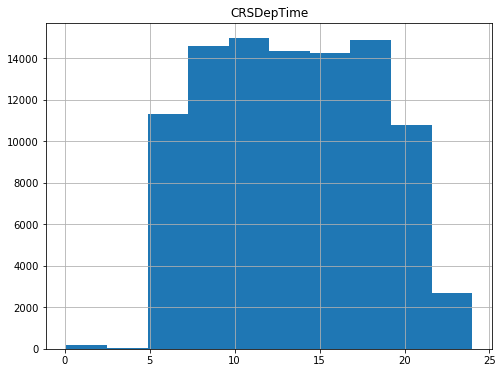

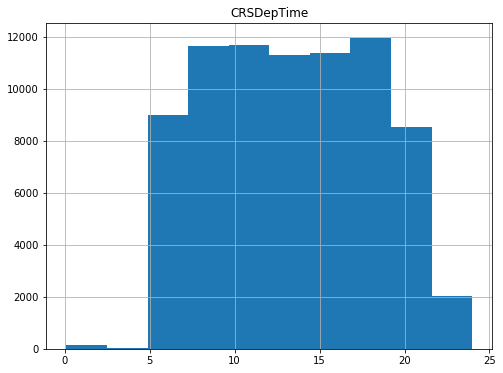

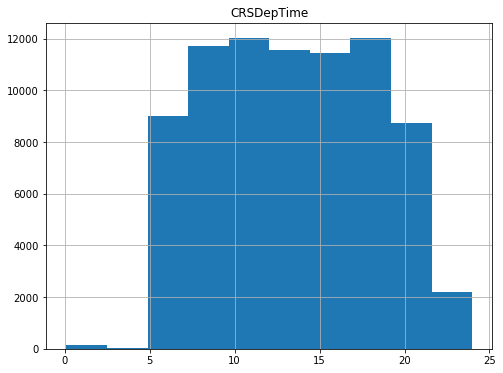

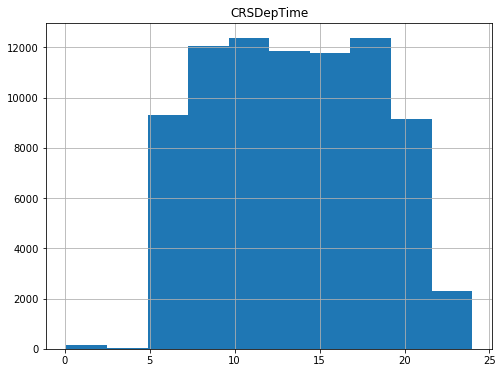

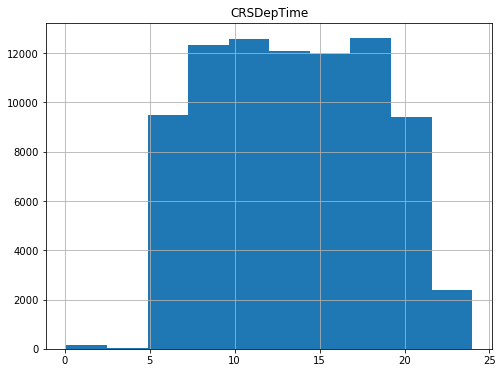

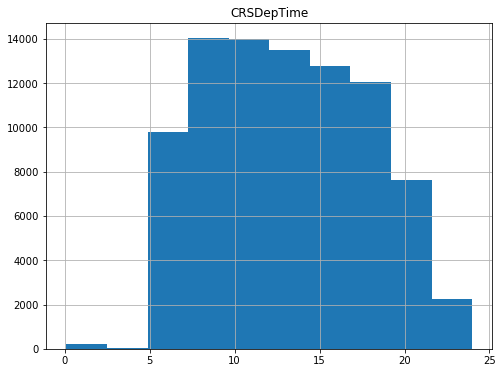

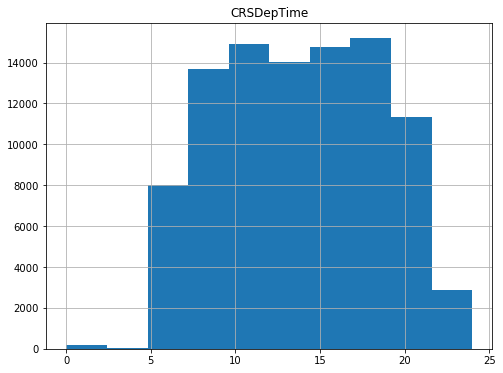

In [21]:
df.groupby('DayOfWeek').hist(column='CRSDepTime', figsize=[8,6])

Monday            Axes(0.1,0.679412;0.235294x0.220588)
Tuesday      Axes(0.382353,0.679412;0.235294x0.220588)
Wednesday    Axes(0.664706,0.679412;0.235294x0.220588)
Thursday          Axes(0.1,0.414706;0.235294x0.220588)
Friday       Axes(0.382353,0.414706;0.235294x0.220588)
Saturday     Axes(0.664706,0.414706;0.235294x0.220588)
Sunday                Axes(0.1,0.15;0.235294x0.220588)
dtype: object

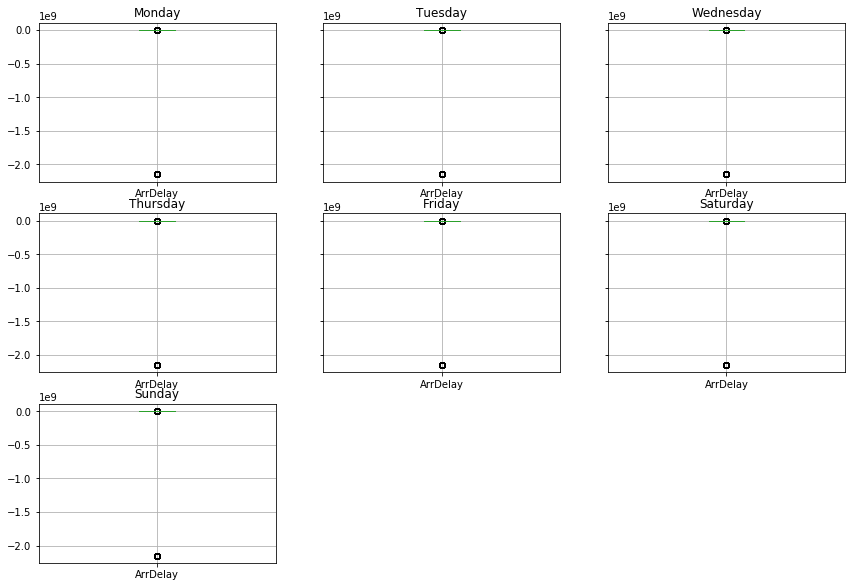

In [22]:
df[df.isnull()== False]
df.groupby('DayOfWeek').boxplot(column='ArrDelay', figsize=[14,10])

In [23]:
len(df.isnull()==False)

600000

In [24]:
from revoscalepy import rx_lin_mod

In [25]:
formula = "ArrDelay ~ DayOfWeek"

In [26]:
lin_mod = rx_lin_mod(formula, data = data_source, compute_context = cc,cube=True)

In [27]:
print(lin_mod)

Call:
rx_lin_mod(formula = 'ArrDelay ~ DayOfWeek', data = <revoscalepy.datasource.RxSqlData.RxSqlServerData object at
    0x000001E29C3C0C88>, pweights = None, fweights = None, cube = True, cube_predictions = False, row_selection = None,
    transforms = None, transform_objects = None, transform_function = None, transform_variables = None,
    transform_packages = None, transform_environment = None, drop_first = False, drop_main = True, cov_coef = False,
    cov_data = False, blocks_per_read = 1, report_progress = None, verbose = 0, compute_context = <class
    'revoscalepy.computecontext.RxInSqlServer.RxInSqlServer'>)

Cube Linear regression Results for: ArrDelay ~ DayOfWeek

Dependent variable(s): ['ArrDelay']
Total independent variables: 7
Number of valid observations: 582628
Number of missing observations: 17372
                            coefficients   ArrDelay
DayOfWeek=Monday        DayOfWeek=Monday  12.025604
DayOfWeek=Tuesday      DayOfWeek=Tuesday  11.293808
DayOfWeek=Wednes

In [28]:
print(lin_mod.summary())

Call:
rx_lin_mod(formula = 'ArrDelay ~ DayOfWeek', data = <revoscalepy.datasource.RxSqlData.RxSqlServerData object at
    0x000001E29C3C0C88>, pweights = None, fweights = None, cube = True, cube_predictions = False, row_selection = None,
    transforms = None, transform_objects = None, transform_function = None, transform_variables = None,
    transform_packages = None, transform_environment = None, drop_first = False, drop_main = True, cov_coef = False,
    cov_data = False, blocks_per_read = 1, report_progress = None, verbose = 0, compute_context = <class
    'revoscalepy.computecontext.RxInSqlServer.RxInSqlServer'>)

Cube Linear regression Results for: ArrDelay ~ DayOfWeek

Dependent variable(s): ['ArrDelay']
Total independent variables: 7
Number of valid observations: 582628
Number of missing observations: 17372
                            coefficients   ArrDelay
DayOfWeek=Monday        DayOfWeek=Monday  12.025604
DayOfWeek=Tuesday      DayOfWeek=Tuesday  11.293808
DayOfWeek=Wednes